In [1]:
import numpy as np
import GPy
import matplotlib.pyplot as plt
from tqdm import trange
from scipy.stats import norm, beta
from scipy.optimize import minimize, differential_evolution
import seaborn as sns
from time import time

In [2]:
RANK = 1 # Раземерность куба, на котором определена наша функция
L = np.array([4]) # Куб будет со стороной 2*L и центром в 0

Будем искать глобальный минимум такой функции (он около $x=-3$).

In [3]:
def f(x):
    x = x * 2.5
    y = 0
    for i in range(RANK):
        y = y + np.sin(x[:, i]) * np.sin(x[:, i]**2 / np.pi) + 0.01 * x[:, i]
    return y/4 + 0.5

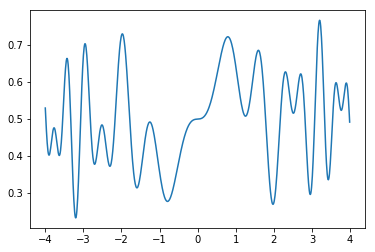

In [4]:
x = np.arange(-L,L,0.01).reshape(-1,RANK)
plt.plot(x, f(x))
plt.show()

В качестве метрики успешности метода я использую минимальное засемпленное значение (от 0 до N), делёное на N:

In [5]:
def get_progress(Y):
    return np.minimum.accumulate(Y/N)

Эта функция вычисляет чёрный ящик (т.е. по переданному $x$ генерирует значение из $Bin(N, f(x))$)

In [6]:
def generate_value(f, x, sigma=0.01):
    return np.random.binomial(N, f(x)).reshape(x.shape[0], 1)

Функции, отвечающие за оптимизацию с использованием гауссовой регрессии

In [7]:
def EI(x, model, opt_value):
    mean_value, variance_value = model.predict(x.reshape(1,RANK))
    std_value = np.sqrt(variance_value)
    improvement = (opt_value - mean_value).ravel()
    std_value = std_value.ravel()
    EI = improvement * norm.cdf(improvement / std_value) + std_value * norm.pdf(improvement / std_value)    
    return EI

In [8]:
def get_new_point(X, Y, model, opt_value):

    starting_points = np.random.uniform(-L, L, [10, RANK])
    
    max_EI = np.inf
    for starting_point in starting_points:
        current_EI = minimize(lambda t: -EI(t, model, opt_value), starting_point, \
                            method='L-BFGS-B', bounds=np.array([-L,L]*RANK).reshape(RANK,2))
        if current_EI.fun < max_EI:
            max_EI = current_EI.fun
            new_point = current_EI.x.reshape(1,RANK)
    new_value = generate_value(f, new_point)
    

    return new_point, new_value

Функции, отвечающие за оптимизацию с использованием биномиальной регрессии

In [9]:
def EI_approx(x, model, opt_value):
    mean_value, variance_value = model._raw_predict(x.reshape(1,RANK))
    std_value = np.sqrt(variance_value)
    EI = []
    binomial = GPy.likelihoods.Binomial()
    n_sample = N
    
    for mean, std in zip(mean_value, std_value):
        samples = np.random.normal(mean, std, n_sample)
        samples = samples[binomial.gp_link.transf(samples)<opt_value]
        if len(samples) > 0:
            EI.append(np.mean(opt_value - binomial.gp_link.transf(samples)))
        else:
            EI.append(0)   
    return np.array(EI)

In [10]:
def get_new_point_approx(X, Y, model, opt_value):

    starting_points = np.random.uniform(-L, L, [10, RANK])
    
    max_EI = np.inf
    for starting_point in starting_points:
        current_EI = minimize(lambda t: -EI_approx(t, model, opt_value), starting_point, \
                            method='L-BFGS-B', bounds=np.array([-L,L]*RANK).reshape(RANK,2))
        if current_EI.fun < max_EI:
            max_EI = current_EI.fun
            new_point = current_EI.x.reshape(1,RANK)
    new_value = generate_value(f, new_point)
    

    return new_point, new_value

В этом эксперименте мы сравним, насколько близко будет уменьшаться минимальное зафиксированное значение в случае с биномиальной/гауссовой регрессиями при разных $N \in [40,70,100]$. Отличие от предыдущей тетрадки в том, что теперь мы сравниваем не просто итерации оптимизации, а учитываем затраченное время.

In [11]:
def experiment(N):
    X = np.zeros([1,RANK])
    Y = generate_value(f, X)
    opt_value = np.min(Y)
    ker = GPy.kern.RBF(RANK, variance=1)
    m = GPy.models.GPRegression(X, Y, ker, noise_var=0.0001)
    
    t1 = time()
    for _ in range(150):
        m = GPy.models.GPRegression(X, Y, ker, noise_var=0.0001)
        x,y = get_new_point(X, Y, m, opt_value)
        X = np.append(X, x, axis=0)
        Y = np.append(Y, y, axis=0)
        opt_value = np.min(Y)
    t1 = t1 - time()
    q1 = get_progress(Y)
    
    X = np.zeros([1,RANK])
    Y = generate_value(f, X)
    trials = np.ones(X.shape, dtype='int') * N
    opt_value = np.min(Y)
    kernel = GPy.kern.RBF(1, variance=1)
    binomial = GPy.likelihoods.Binomial()
    m = GPy.core.GP(X, Y, kernel=kernel, 
                                  Y_metadata={'trials': trials},
                                  inference_method=GPy.inference.latent_function_inference.Laplace(),
                                  likelihood=binomial)
    t2 = time()
    for _ in range(20):
        trials = np.ones(X.shape, dtype='int') * N
        Y = generate_value(f, X)
        kernel = GPy.kern.RBF(1, variance=1)
        binomial = GPy.likelihoods.Binomial()
        m = GPy.core.GP(X, Y, kernel=kernel, 
                                  Y_metadata={'trials': trials},
                                  inference_method=GPy.inference.latent_function_inference.Laplace(),
                                  likelihood=binomial)
        x,y = get_new_point_approx(X, Y, m, opt_value)
        X = np.append(X, x, axis=0)
        Y = np.append(Y, y, axis=0)
        opt_value = np.min(Y)
    t2 = t2 - time()    
    q2 = get_progress(Y)
    
    return q1, q2, t1, t2

Усредним по 20'и запускам

100%|██████████| 20/20 [05:29<00:00, 16.46s/it]


Binomial is slower  1.9219095067963303  times
Binomial is worse  25.1798561151  percents


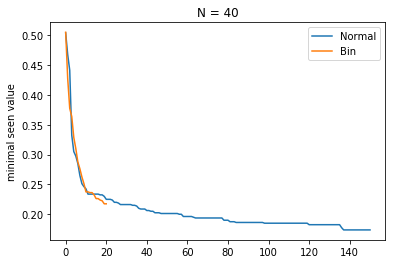

100%|██████████| 20/20 [06:43<00:00, 20.16s/it]


Binomial is slower  1.4822371578389482  times
Binomial is worse  12.1771217712  percents


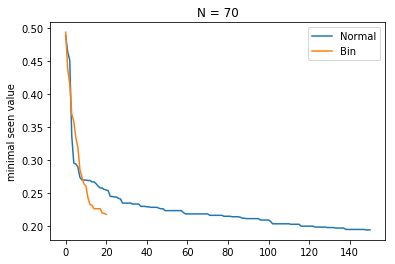

100%|██████████| 20/20 [07:43<00:00, 23.20s/it]


Binomial is slower  1.3726839797239918  times
Binomial is worse  18.7675070028  percents


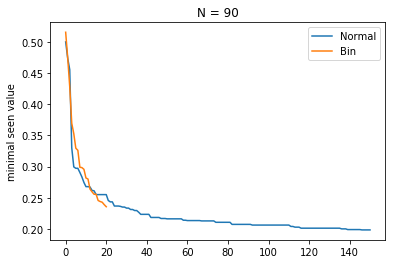

In [12]:
for N in [40, 70, 90]:
    Q1 = []
    Q2 = []
    T1, T2 = [], []
    for _ in trange(20):
        q1, q2, t1, t2 = experiment(N)
        Q1.append(q1)
        Q2.append(q2)
        T1.append(t1)
        T2.append(t2)
    print('Binomial is slower ', sum(T2)/sum(T1), ' times')
    print('Binomial is worse ', (np.min(np.mean(Q2, axis=0)) - np.min(np.mean(Q1, axis=0)))/np.min(np.mean(Q1, axis=0)) * 100, ' percents')
    plt.ylabel('minimal seen value')
    plt.title('N = '+str(N))
    plt.plot(np.mean(Q1, axis=0), label='Normal')
    plt.plot(np.mean(Q2, axis=0), label='Bin')
    plt.legend()
    plt.show()

Таким образом, биномиальная оптимизация медленнее и хуже, чем гауссовская (хотя, если брать в расчёт только итерации, биномиальная лучше)